# Week 1

In [167]:
import numpy as np
from astropy.io import fits
path = '/media/arihant/Importants/Astronomy/Data Driven Astronomy/Data_Driven_Astronomy_Data/'

The pulsars have a very feeble signal to noise ratio, hence they are buried in the noise and hence hard to detect. It is also possible that they might be visible in one of the captures but not in the other. A mean stack adds up all the values for each pixel in all the images hence increasing the signal to noise ratio.

- This is because the noise is mean randomly distributed, that its mean would turn out to be zero. Hence the noise cancels out leaving out the signal from the pulsar. 

- But is some cases when the data is skewed, it is better to use the Median as it is a better indicator of the data as compared to the mean. This is becase the median is not affected by the presence of outliers, whereas the mean gets deflected when there is a substantial presence of out

## Mean Stack

The value of central pixel is:  0.01517697935923934


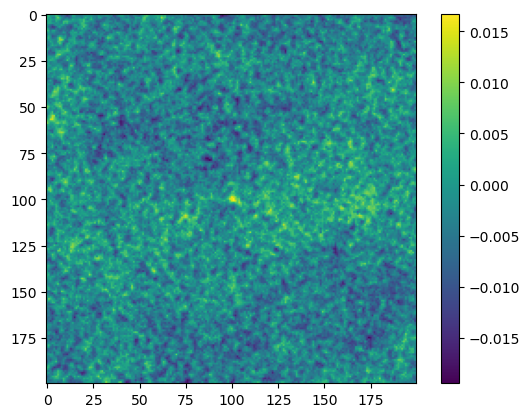

In [168]:
def mean_fits(files):
  data_all = []
  for i in files:
    hdulist = fits.open(path+i)
    data_all.append(hdulist[0].data)
  sh = data_all[0].shape
  s = np.zeros(sh)
  for i in data_all:
    s+=i
  s = s/len(data_all)
  return s
  
# Test your function with examples from the question
data  = mean_fits(['image0.fits', 'image1.fits', 'image2.fits','image3.fits'])
print("The value of central pixel is: ",data[100, 100])

# You can also plot the result:
import matplotlib.pyplot as plt
plt.imshow(data.T, cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

## Median Stack

0.010775766335427761 0.013172931000099197 88
0.011797304265201092 0.07075870399967243 184
The mean Image stack


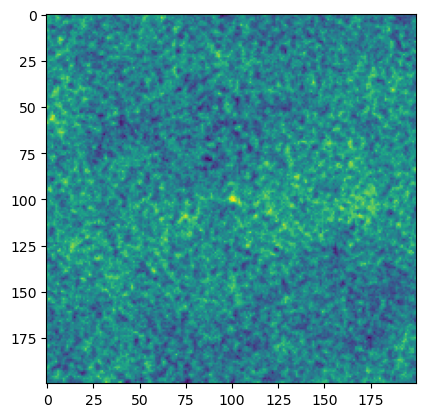

The median Image stack


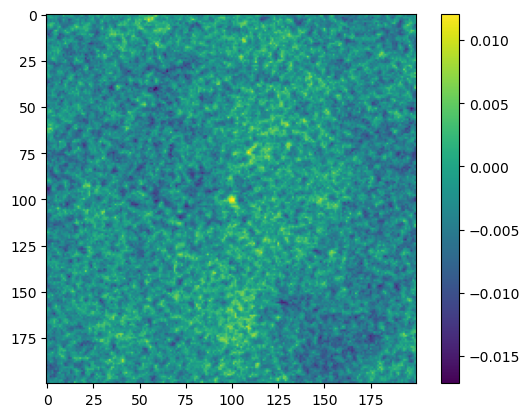

In [6]:
import numpy as np
import statistics
from astropy.io import fits
import time
import sys


def median_fits(files):
    data_all = []
    fitsall = []
    start = time.perf_counter()
    for i in files:
        hdulist = fits.open(path + i)
        fitsall.append(hdulist)
        data_all.append(hdulist[0].data)
    shape = data_all[0].shape
    stack = np.vstack([im.flatten() for im in data_all])
    median = np.median(stack, axis=0).reshape(shape)
    end = time.perf_counter() - start
    memory = sys.getsizeof(fitsall)
    return (median, end, memory)


# Run your function with first example in the question.
result = median_fits(['image0.fits', 'image1.fits'])
print(result[0][100, 100], result[1], result[2])

# Run your function with second example in the question.
result1 = median_fits(['image{}.fits'.format(str(i)) for i in range(11)])
print(result1[0][100, 100], result1[1], result1[2])

# You can also plot the result:
import matplotlib.pyplot as plt

print('The mean Image stack')
plt.imshow(data.T, cmap=plt.cm.viridis)
plt.show()
print('The median Image stack')
plt.imshow(result1[0], cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

## Bin Approximation Method for Median Calculation

Calculation of the median requires all the data to be in the memory at once, this becomes an issue when we have a large dataset, with hundereds of FITS files. Hence we have a method called the `running median` which saves space by loading only 1 image at a time. 

### Bin Approx Algorithm

The idea is to find the median from the data's histogram The full algorithm for N datapoints works as:

- Calculate their mean and standard deviation, $\mu$ and $\sigma$.
- Set the bounds: `minval`$=\mu-\sigma$ and `maxval`$=\mu+\sigma$. Any `value`$\geq$ `maxval` is ignored.
- Set the bin width: `width` = $\frac{2\sigma}{B}$. Where $B$ is the total number of bins to be made. 
- Make an ignore bin for counting `value`$<$`minval`.
- Make $B$ bins for counting values in `minval` and `maxval`. Eg the first bin is `minval`$\leq$`value`$<$`minval`+`width`.
- Count the number of values that fall into each bin. 
- Sum these counts until `total`$\geq(N+1)/2$. Remember to start from the ignore bin. 
- Return the midpoint of the bin that exceeded (N+1)/2.

In [164]:
import numpy as np


def median_bins(arr, b):
    m, s = np.mean(arr), np.std(arr)
    minval, maxval = m - s, m + s
    arr = [i for i in arr if i < maxval]
    w = 2 * s / b
    bins = np.arange(minval, maxval + w, w)
    c = len([i for i in arr if i < minval])
    final = np.histogram(arr, bins)

    return (m, s, c, np.array(final[0]))


def median_approx(arr, b):
    m, s = np.mean(arr), np.std(arr)
    minval, maxval = m - s, m + s
    length = (len(arr) + 1) / 2
    arr = [i for i in arr if i < maxval]
    w = 2 * s / b
    bins = np.arange(minval, maxval + w, w)
    c = len([i for i in arr if i < minval])
    final = np.histogram(arr, bins)
    counts = final[0]
    sum_bins = [c]
    s = c
    for i in counts:
        s += i
        sum_bins.append(s)
    for i in range(len(sum_bins)):
        if sum_bins[i] >= length:
            c = i
            break
        else:
            c = len(sum_bins) - 1
    median = (bins[c - 1] + bins[c]) / 2
    return median


print(median_bins([1, 1, 3, 2, 2, 6], 3))
print("Median: ", median_approx([1, 1, 3, 2, 2, 6], 3), "\n")
print(median_bins([1, 5, 7, 7, 3, 6, 1, 1], 4))
print("Median: ", median_approx([1, 5, 7, 7, 3, 6, 1, 1], 4), "\n")
print(median_bins([0, 1], 5))
print("Median: ", median_approx([0, 1], 5), "\n")

(2.5, 1.707825127659933, 0, array([2, 3, 0]))
Median:  2.5 

(3.875, 2.521780125229002, 3, array([0, 1, 1, 1]))
Median:  4.50544503130725 

(0.5, 0.5, 0, array([1, 0, 0, 0, 0]))
Median:  0.9 



## Bin Approximation of FITS Files

In [178]:
def mean_fits(files):
    data_all = []
    for i in files:
        hdulist = fits.open(path+i)
        data_all.append(hdulist[0].data)
    sh = data_all[0].shape
    m = np.zeros(sh)
    for i in data_all:
        m+=i
        m = m/len(data_all)
    
    std = np.vstack(i.ravel() for i in data_all)
    s = np.std(std,axis=0)
    s.reshape(sh)
    return s

data = mean_fits(['image0.fits', 'image1.fits', 'image2.fits','image3.fits'])
print(data)

[0.0018459  0.00568334 0.00489995 ... 0.00354149 0.00209633 0.00026814]


/tmp/ipykernel_25509/3789871021.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  std = np.vstack(i.ravel() for i in data_all)


## Further Reading

**1. Pulsars**

- Introduction to Pulsars (from CSIRO, beginner) Hobbs, M. (n.d.). An introduction to pulsars. Retrieved February 14, 2017, from http://www.atnf.csiro.au/outreach/education/everyone/pulsars/index.html 

- Pulsar Properties (from NRAO, advanced) National Radio Astronomy Observatory. (2010).  Pulsar Properties. Retrieved February 14, 2017, from http://www.cv.nrao.edu/course/astr534/Pulsars.html

**2. Statistics**
- Additional material located here: Department of Physics and Astronomy, University of British Columbia. (n.d.). Practical Statistics for Astronomers. Retrieved from http://www.astro.ubc.ca/people/jvw/ASTROSTATS/ 



# Week 2